In [221]:
import librosa
import matplotlib.pyplot as plt
import scipy.io.wavfile
import numpy as np
import math
from silero_vad import load_silero_vad, read_audio, get_speech_timestamps

In [222]:
#all the audio samples are single-channel(mono)
sampleRate, audio = scipy.io.wavfile.read('audioData/Animals/bird/3e31dffe_nohash_0.wav')
audio=audio[0:int(3.5*sampleRate)]
sampleRate=audio.size

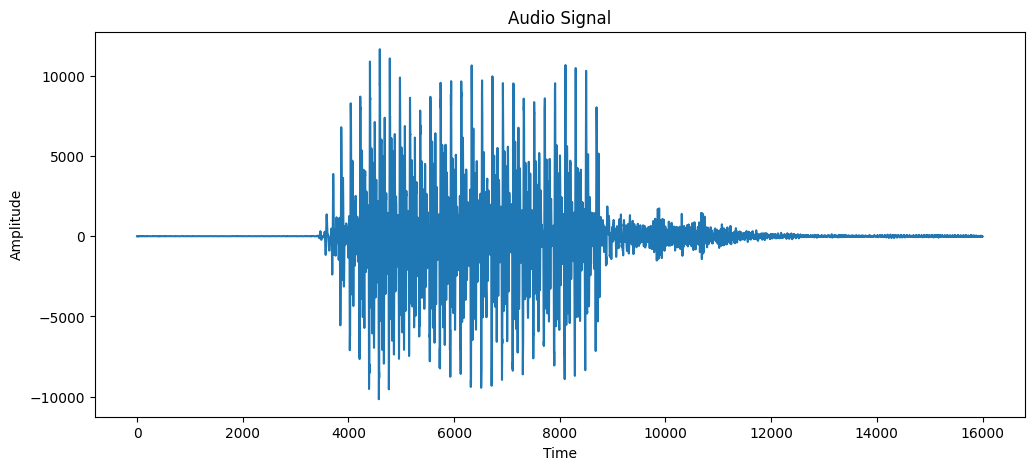

In [223]:
#Time vs Amplitude Graph of wav file
plt.figure(figsize=(12,5))
plt.plot(audio)
plt.xlabel("Time")
plt.ylabel("Amplitude")
plt.title("Audio Signal")
plt.show()

In [224]:
model = load_silero_vad()
wav = read_audio('audioData/Animals/bird/0a7c2a8d_nohash_0.wav')
speech_timestamps = get_speech_timestamps(
  wav,
  model
)
print(speech_timestamps)

[{'start': 7200, 'end': 16000}]


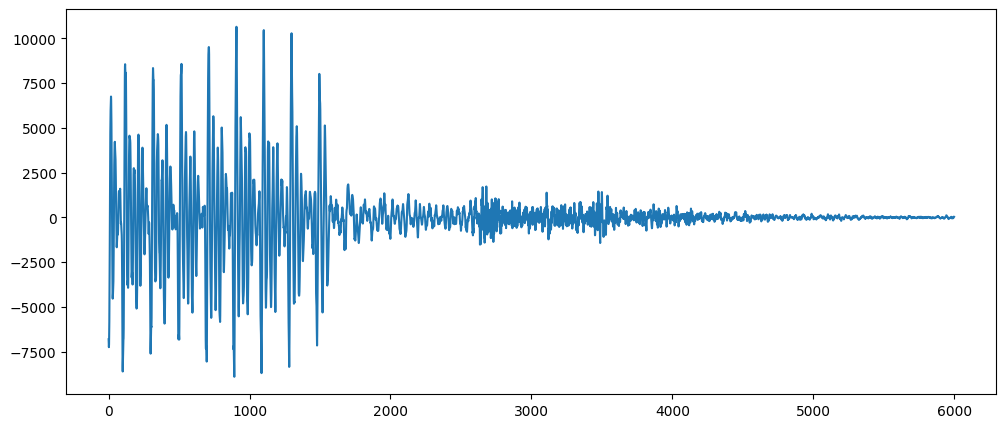

In [225]:
plt.figure(figsize=(12,5))
plt.plot(audio[speech_timestamps[0]['start']:speech_timestamps[0]['start']+6000])
plt.show()

audio=audio[speech_timestamps[0]['start']:speech_timestamps[0]['start']+6000]
sampleRate=audio.size

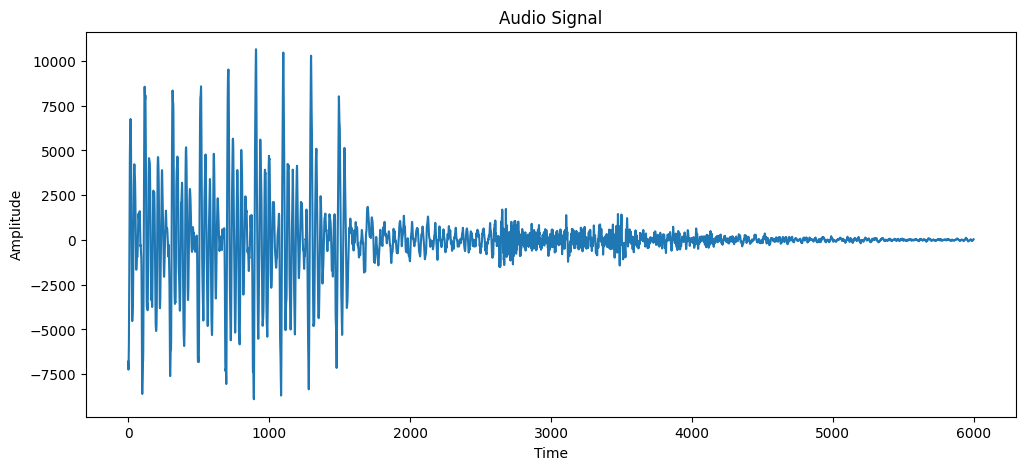

In [226]:
#Time vs Amplitude Graph of wav file
plt.figure(figsize=(12,5))
plt.plot(audio)
plt.xlabel("Time")
plt.ylabel("Amplitude")
plt.title("Audio Signal")
plt.show()

In [227]:
# # Containing and isolating only speech by removing silence or hums.
# discard_threshold=max(audio)*0.15
# fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 4))
# ax1.plot(audio)
# boundLeft=0
# for i in range(0,sampleRate):
#     if(audio[i]>=discard_threshold):
#         if(i>1000):
#             boundLeft=i-1000
#         else:
#             boundLeft=i
#         break
# boundRight=0
# for i in range(sampleRate-1,-1,-1):
#     if(audio[i]>=discard_threshold):
#         if(i<15000):
#             boundRight=i+1000
#         else:
#             boundRight=i
#         break

# audio=audio[boundLeft:boundRight]
# sampleRate=audio.size
# plt.plot(audio)

In [228]:
# To generate MFCC, we follow the following steps:
# audioInput -> pre-emphasis -> framing -> windowing -> fourier transform -> Inverse Mel Scale Filter Bank -> Log() -> DCT ->
# Derivatives -> Feature Vector

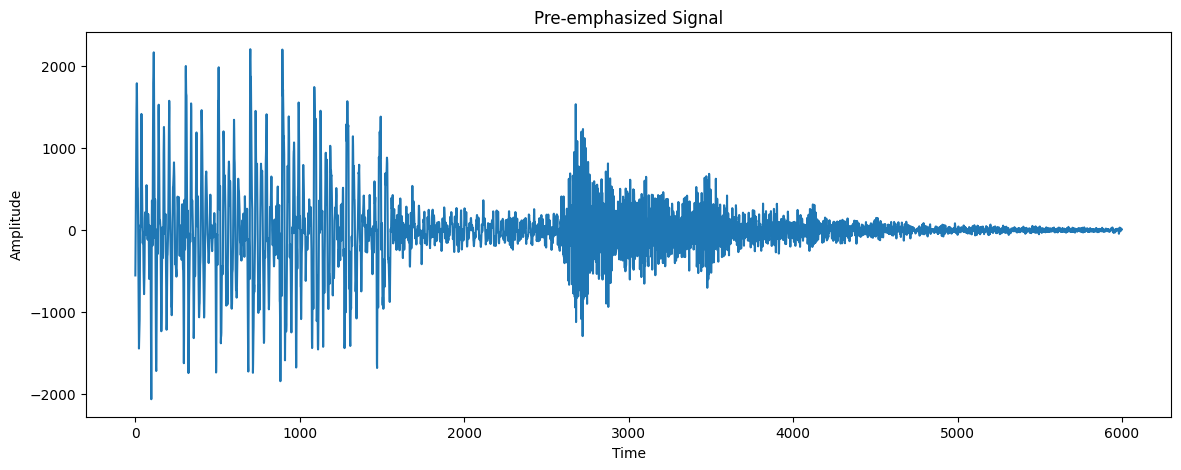

In [229]:
# Pre-emphasis layer
# Amplifies higher frequencies in order to balance the spectrum (higher frequencies have lower energies)
pre_emphasis = 0.97
audio_preemphasized=[]
for i in range(1,sampleRate):
    audio_preemphasized=np.append(audio_preemphasized,audio[i]-(audio[i-1]*pre_emphasis))

# Plot the pre-emphasized signal
plt.figure(figsize=(14, 5))
plt.plot(audio_preemphasized)
plt.title('Pre-emphasized Signal')
plt.xlabel('Time')
plt.ylabel('Amplitude')
plt.show()

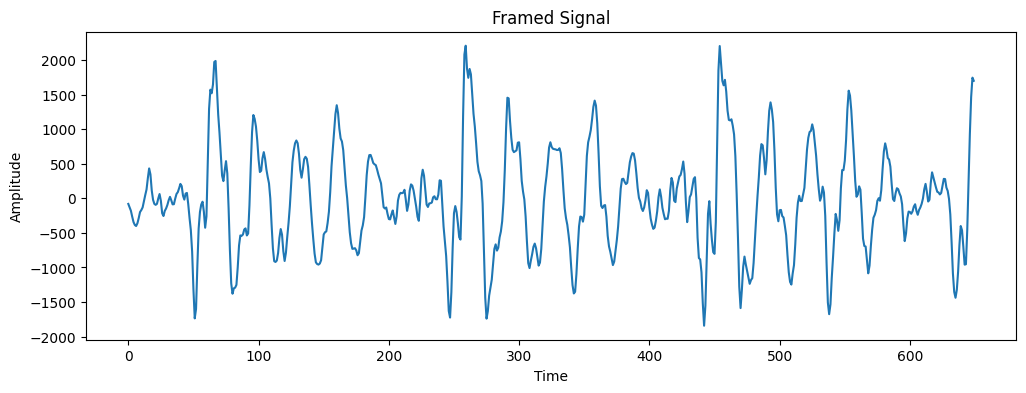

In [230]:
# Framing Layer
# Since the audio wave is more than a second, windowing is necesarry in order to fully capture the features and allow for correct
# calculations to be performed. Thus, for ease of calculations, we slice the wave.
# The signal/wave is separated into sections or frames of 25-30 milliseconds.
# Since some parts of the signal are always at the ends of the frames, and we have to perform hamming window, this may result in data loss.
# To tackle this, we frame-shift with a stride of 15ms. This ensures that parts of signals get to be in the center of the signal.

shift_stride=220  # ~10 millisecond of stride
frame_size=650 # ~30 millisecond frame
audio_frames=[]

# Produces 65 audio frames
for i in range(0,sampleRate-frame_size,shift_stride):
    audio_frames.append(audio_preemphasized[i:i+frame_size])

plt.figure(figsize=(12,4))
plt.plot(audio_frames[2])
plt.title('Framed Signal')
plt.xlabel('Time')
plt.ylabel('Amplitude')
plt.show()

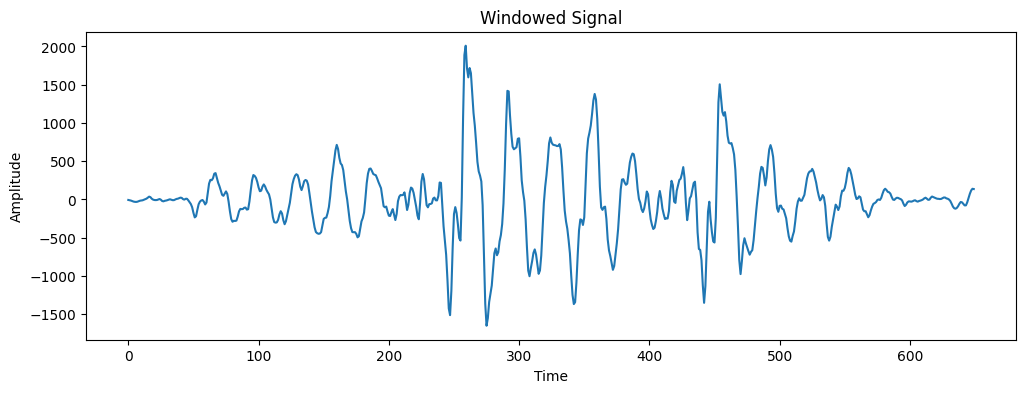

In [231]:
# Windowing Layer
# Since sudden increase/decrease of amplitude at the edges of the frames create noisy outcomes, we have to smoothen it.
# Thus, we apply hamming window

hammed_audio=[]
for frame in audio_frames:
    temp_hammed_audio=[]
    for i in range(0,frame_size):
        temp_hammed_audio.append(frame[i]*(0.54-0.46*math.cos(2*math.pi*i/(frame_size-1))))
    
    hammed_audio.append(temp_hammed_audio)

plt.figure(figsize=(12,4))
plt.plot(hammed_audio[2])
plt.title('Windowed Signal')
plt.xlabel('Time')
plt.ylabel('Amplitude')
plt.show()

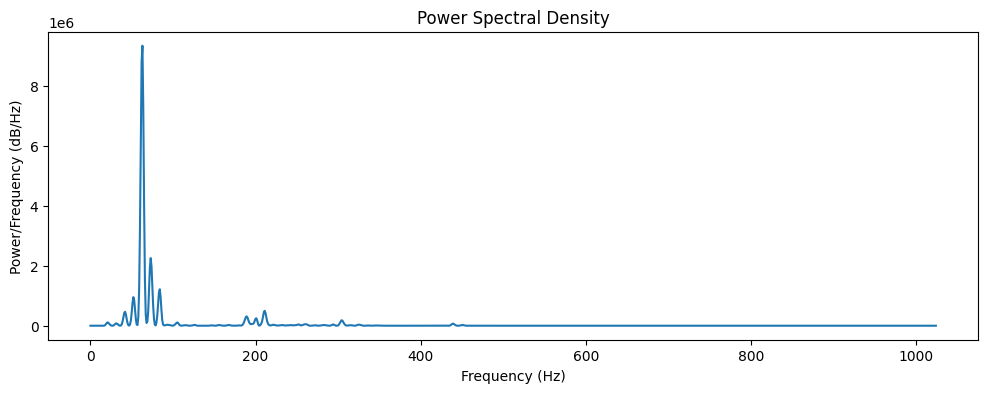

In [232]:
# FFT(Fast Fourier Transform) Layer
# Used to convert time-domain signal to frequency-domain to analyze frequency components of speech.
# Output of FFT gives complex frequency spectrum (both magnitude and phase)
# Since we only need magnitude, we evaluate the power spectrum from the output of FFT
# NFFT specifies number of points for the FFT. The output is NFFT/2 points

NFFT=2048
complex_power_spectrums=np.fft.rfft(hammed_audio,NFFT)
power_spectrum=(1/NFFT)*pow(np.abs(complex_power_spectrums),2)

plt.figure(figsize=(12,4))
plt.plot(power_spectrum[2])
plt.title("Power Spectral Density")
plt.xlabel("Frequency (Hz)")
plt.ylabel("Power/Frequency (dB/Hz)")
plt.show()

In [233]:
# Mel-filter banks
# Mel-scale related to human-percieved frequency to its actual frequency. Since humans do not hear sound linearly,
# i.e, linear gaps in frequency does not amount to linear change in pitch, we use mel-scale.
# Mel-scale is a logarithm scale, which imitates hearing of humans. Thus, it enables us to capture features as if heard by human.

# Computing the Mel-Filter bank
# 1. Decide upper and lower frequencies in Hertz(SampleRate/2 and 300Hz repectively) 
# 2. Convert them to mels.
# 3. Compute 12 linearly-spaced frequencies inclusive of lower and upper mels.
# 4. Convert these points back to Hertz.
# 5. Round the frequencies to their nearest FFT Bins.
# 6. Create Filterbanks

mels=0
freq_to_mel=lambda freq:1125*math.log(1+freq/700)
lower_hz=300
upper_hz=sampleRate/2

lower_mel=freq_to_mel(lower_hz)
upper_mel=freq_to_mel(upper_hz)

n_filters=40
mel_arr=np.linspace(lower_mel,upper_mel,n_filters+2)
hz_arr=[700*(math.exp((i/1125))-1) for i in mel_arr]

freq_bin=[math.floor((NFFT+1)*hz_arr_i/sampleRate) for hz_arr_i in hz_arr]
print(freq_bin)


[102, 113, 124, 136, 148, 161, 174, 187, 201, 216, 230, 246, 261, 278, 294, 312, 329, 348, 367, 387, 407, 428, 450, 472, 495, 519, 543, 569, 595, 622, 650, 679, 709, 739, 771, 804, 838, 873, 909, 946, 984, 1024]


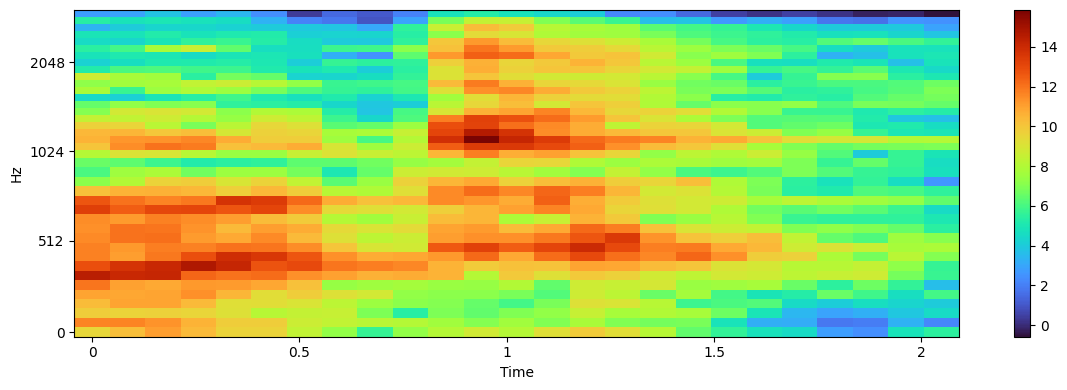

In [234]:
# computing the filterbanks
temp_filter_bank=np.zeros((n_filters,int((NFFT/2))+1))
for i in range(1,n_filters+1):
    for k in range(0,int((NFFT/2))):  #frame length
        if k<freq_bin[i]:
            temp_filter_bank[i-1][k]=0
        elif freq_bin[i-1]<=k and k<=freq_bin[i]:
            temp_filter_bank[i-1][k]=(k-freq_bin[i-1])/(freq_bin[i]-freq_bin[i-1])
        elif freq_bin[i]<=k and k<=freq_bin[i+1]:
            temp_filter_bank[i-1][k]=(freq_bin[i+1]-k)/(freq_bin[i+1]-freq_bin[i])
        else:
            temp_filter_bank[i-1][k]=0


filter_banks=np.dot(power_spectrum, temp_filter_bank.T)
filter_banks=np.where(filter_banks == 0, np.finfo(float).eps, filter_banks)
filter_banks=np.log(filter_banks+1e-8)

plt.figure(figsize=(12, 4))
librosa.display.specshow(filter_banks.T, sr=sampleRate, x_axis='time', y_axis='mel',cmap='turbo')
plt.colorbar()
plt.tight_layout()
plt.show()

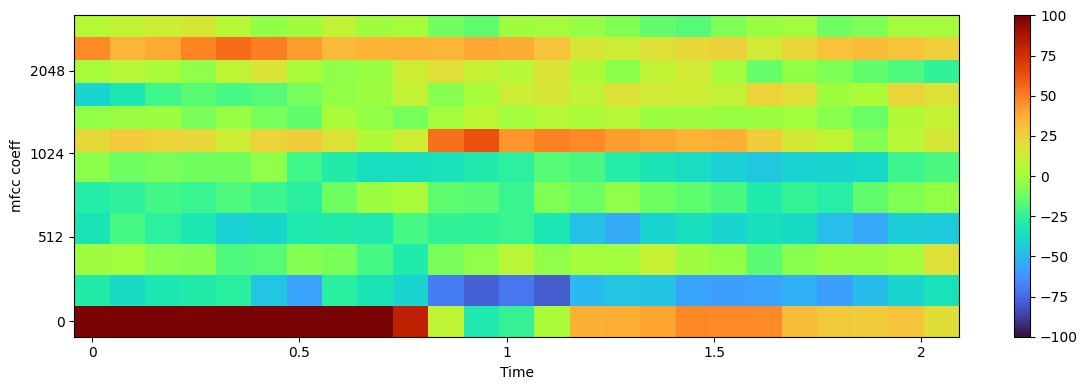

In [235]:
# Generate MFCCs
# We apply DCT on the filterbanks to obtain a set of 26 Mel-Frequency Cepstral Coefficients.
# We only require first 13 coefficients for ASR purposes. Rest are to be discarded.

from scipy.fftpack import dct
mfcc = dct(filter_banks, type=2, axis=1)[:, 1:13] # Keep 2-13

plt.figure(figsize=(12, 4))
librosa.display.specshow(mfcc.T, sr=sampleRate, x_axis='time', y_axis='mel',cmap='turbo',vmin=-100,vmax=100)
plt.colorbar()
plt.ylabel("mfcc coeff")
plt.tight_layout()
#s=f"C:/Users/svija/Downloads/outputs/{file}.png"
#plt.savefig("C:/Users/svija/Downloads/outputs/.png")
plt.show()